## 基础演化策略

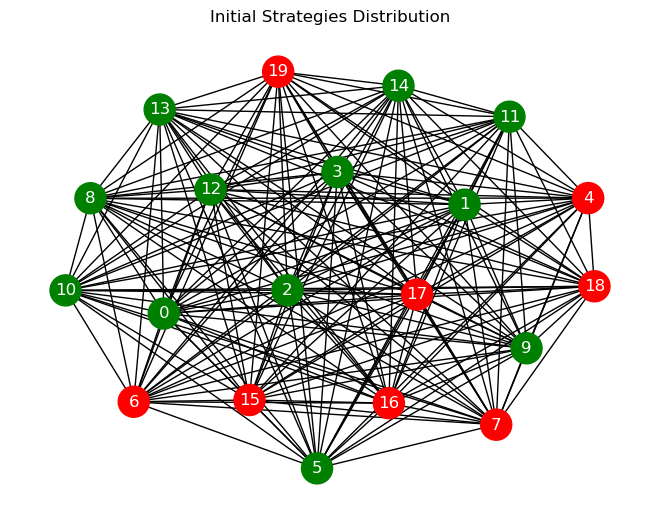

合作个体数量: 20
背叛个体数量: 0


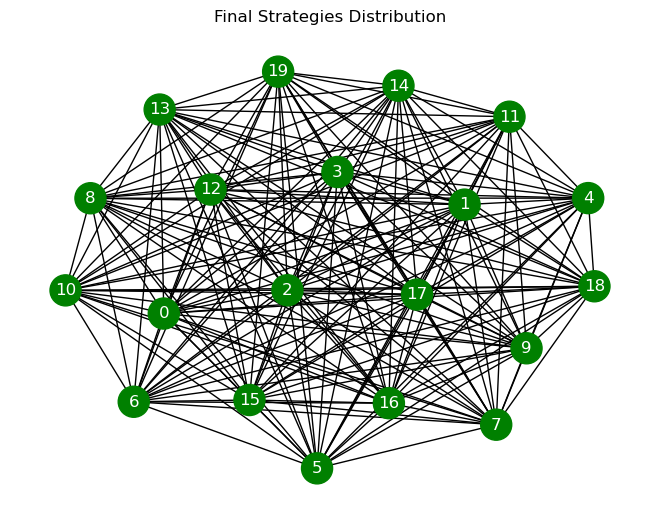

In [53]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# 定义奖励矩阵
reward_matrix = {
    ('C', 'C'): (3, 3),
    ('C', 'D'): (-1, 4),
    ('D', 'C'): (4, -1),
    ('D', 'D'): (0, 0)
}

# 初始化图
G = nx.Graph()

# 添加节点 (个体) 和初始策略
num_individuals = 20
strategies = ['C', 'D']  # C: 合作, D: 背叛

for i in range(num_individuals):
    G.add_node(i, strategy=random.choice(strategies))

# 添加边 (表示个体之间的相互作用)
for i in range(num_individuals):
    for j in range(i+1, num_individuals):
        G.add_edge(i, j)

# 绘制初始策略分布
pos = nx.spring_layout(G)
initial_strategies = [G.nodes[i]['strategy'] for i in G.nodes()]
colors = ['green' if strategy == 'C' else 'red' for strategy in initial_strategies]
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500, font_color='white')
plt.title('Initial Strategies Distribution')
plt.show()

# 进行多轮博弈并更新策略
num_rounds = 100

for _ in range(num_rounds):
    new_strategies = {}
    for i in G.nodes():
        neighbors = list(G.neighbors(i))
        cooperate_count = sum(1 for neighbor in neighbors if G.nodes[neighbor]['strategy'] == 'C')
        defect_count = len(neighbors) - cooperate_count
        
        # 更新策略：根据邻居中多数的策略来更新
        if cooperate_count > defect_count:
            new_strategies[i] = 'C'
        else:
            new_strategies[i] = 'D'
    
    # 应用新的策略
    for i in new_strategies:
        G.nodes[i]['strategy'] = new_strategies[i]

# 输出最终的策略分布
final_strategies = [G.nodes[i]['strategy'] for i in G.nodes()]
cooperate_count = final_strategies.count('C')
defect_count = final_strategies.count('D')

print(f"合作个体数量: {cooperate_count}")
print(f"背叛个体数量: {defect_count}")

# 绘制最终策略分布
colors = ['green' if strategy == 'C' else 'red' for strategy in final_strategies]
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500, font_color='white')
plt.title('Final Strategies Distribution')
plt.show()


## 亲属选择

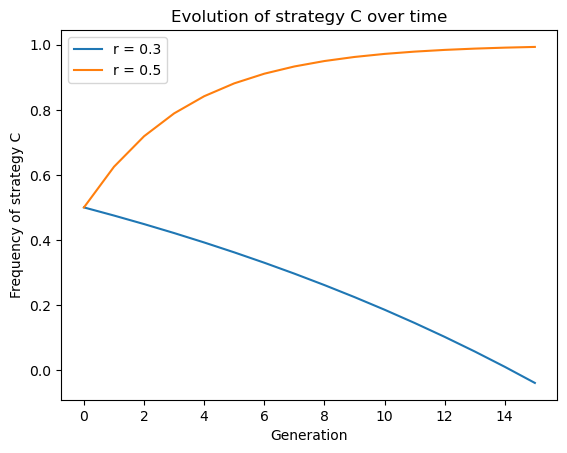

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_payoffs(r, b, c, x):
    payoff_C = r * (b - c) + (1 - r) * ((b - c) * x - c * (1 - x))
    payoff_D = (1 - r) * b * x
    return payoff_C, payoff_D

def evolutionary_dynamics(r, b, c, generations=100, population_size=100):
    # 初始采用策略 C 的个体比例
    x = 0.5
    frequencies = [x]

    for _ in range(generations):
        payoff_C, payoff_D = calculate_payoffs(r, b, c, x)
        avg_payoff = x * payoff_C + (1 - x) * payoff_D

        # 检查避免除零错误
        if avg_payoff == 0:
            avg_payoff = 1e-10  # 设置一个非常小的默认值

        # 更新采用策略 C 的个体比例
        x = x * (payoff_C / avg_payoff)
        frequencies.append(x)

    return frequencies

# 参数
b = 3.0  # 收益
c = 1.0  # 成本
generations = 15

# 运行模拟 r = 0.3
r1 = 0.3  # 亲缘系数 (小于 c/b)
frequencies_r1 = evolutionary_dynamics(r1, b, c, generations)

# 运行模拟 r = 0.5
r2 = 0.5  # 亲缘系数 (大于 c/b)
frequencies_r2 = evolutionary_dynamics(r2, b, c, generations)

# 绘制结果
plt.plot(frequencies_r1, label='r = 0.3')
plt.plot(frequencies_r2, label='r = 0.5')
plt.xlabel('Generation')
plt.ylabel('Frequency of strategy C')
plt.title('Evolution of strategy C over time')
plt.legend()
plt.show()


## 直接互惠

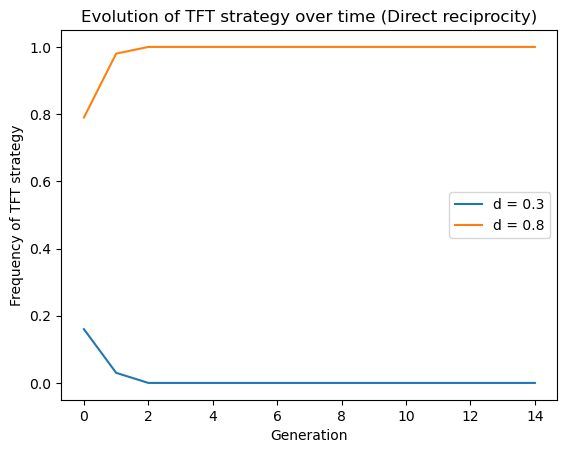

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 定义奖励矩阵
def payoff_matrix(strategy1, strategy2, b, c, d):
    if strategy1 == 'TFT' and strategy2 == 'TFT':
        return (b - c) / (1 - d), (b - c) / (1 - d)
    elif strategy1 == 'TFT' and strategy2 == 'AllD':
        return -c, b
    elif strategy1 == 'AllD' and strategy2 == 'TFT':
        return b, -c
    elif strategy1 == 'AllD' and strategy2 == 'AllD':
        return 0, 0

# 演化动态模拟
def evolutionary_dynamics(b, c, d, generations=100, population_size=100):
    strategies = ['TFT', 'AllD']
    population = [random.choice(strategies) for _ in range(population_size)]
    frequencies = []

    for _ in range(generations):
        payoffs = np.zeros(population_size)
        # 每一代进行多轮博弈，计算累计收益
        for i in range(population_size):
            for j in range(population_size):
                if i != j:
                    strategy_i = population[i]
                    strategy_j = population[j]
                    payoff_i, _ = payoff_matrix(strategy_i, strategy_j, b, c, d)
                    payoffs[i] += payoff_i
        
        new_population = population.copy()
        for i in range(population_size):
            opponent = random.choice(range(population_size))
            if payoffs[opponent] > payoffs[i]:
                new_population[i] = population[opponent]
        
        population = new_population
        frequencies.append(population.count('TFT') / population_size)

    return frequencies

# 参数
b = 3.0  # 收益
c = 1.0  # 成本
generations = 15
population_size = 100

# 运行模拟 d = 0.3
d1 = 0.3  # 折扣因子 (低于 c/b)
frequencies_d1 = evolutionary_dynamics(b, c, d1, generations, population_size)

# 运行模拟 d = 0.8
d2 = 0.8  # 折扣因子 (高于 c/b)
frequencies_d2 = evolutionary_dynamics(b, c, d2, generations, population_size)

# 绘制结果
plt.plot(frequencies_d1, label='d = 0.3')
plt.plot(frequencies_d2, label='d = 0.8')
plt.xlabel('Generation')
plt.ylabel('Frequency of TFT strategy')
plt.title('Evolution of TFT strategy over time (Direct reciprocity)')
plt.legend()
plt.show()


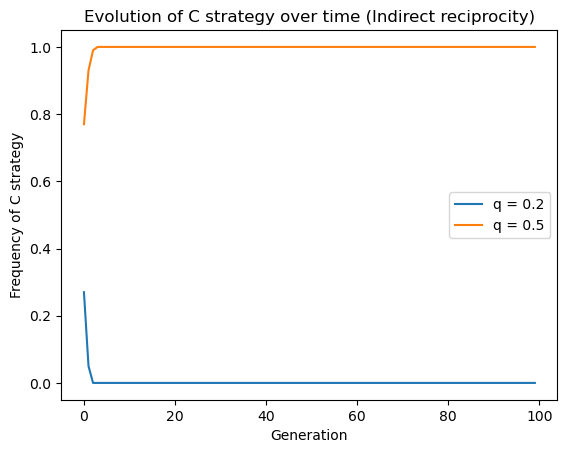

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 定义奖励矩阵
def payoff_matrix(strategy1, strategy2, b, c, q):
    if strategy1 == 'C' and strategy2 == 'C':
        return b - c, b - c
    elif strategy1 == 'C' and strategy2 == 'D':
        return -c * (1 - q), b * (1 - q)
    elif strategy1 == 'D' and strategy2 == 'C':
        return b * (1 - q), -c * (1 - q)
    elif strategy1 == 'D' and strategy2 == 'D':
        return 0, 0

# 演化动态模拟
def evolutionary_dynamics(b, c, q, generations=100, population_size=100):
    strategies = ['C', 'D']
    population = [random.choice(strategies) for _ in range(population_size)]
    frequencies = []

    for _ in range(generations):
        payoffs = np.zeros(population_size)
        # 每一代进行多轮博弈，计算累计收益
        for i in range(population_size):
            for j in range(population_size):
                if i != j:
                    strategy_i = population[i]
                    strategy_j = population[j]
                    payoff_i, payoff_j = payoff_matrix(strategy_i, strategy_j, b, c, q)
                    payoffs[i] += payoff_i
                    payoffs[j] += payoff_j
        
        new_population = population.copy()
        for i in range(population_size):
            opponent = random.choice(range(population_size))
            if payoffs[opponent] > payoffs[i]:
                new_population[i] = population[opponent]
        
        population = new_population
        frequencies.append(population.count('C') / population_size)

    return frequencies

# 参数
b = 3.0  # 收益
c = 1.0  # 成本
generations = 100
population_size = 100

# 运行模拟 q = 0.2
q1 = 0.2  # 信誉概率 (小于 c/b)
frequencies_q1 = evolutionary_dynamics(b, c, q1, generations, population_size)

# 运行模拟 q = 0.5
q2 = 0.5  # 信誉概率 (大于 c/b)
frequencies_q2 = evolutionary_dynamics(b, c, q2, generations, population_size)

# 绘制结果
plt.plot(frequencies_q1, label='q = 0.2')
plt.plot(frequencies_q2, label='q = 0.5')
plt.xlabel('Generation')
plt.ylabel('Frequency of C strategy')
plt.title('Evolution of C strategy over time (Indirect reciprocity)')
plt.legend()
plt.show()
